# Influência de fatores externos no pagamento de dívidas

Quais características influenciam na inadimplência de um cliente? Que tipos de comportamentos podem indicar um possível problema financeiro?

Com um banco de dados proveniente de uma instituição financeira em formato CSV, vamos analisar tudo isso. Daremos atenção especial à segunda coluna, chamada de default, que indica se um cliente é adimplente (default = 0), ou inadimplente (default = 1). Queremos entender qual a ligação entre um cliente deixar de honrar com suas dívidas e atributos como salário, escolaridade e movimentação financeira.

## 1. Importando o banco de dados

In [1]:
import pandas as pd

# Primeiro, vamos importar o banco de dados de uma URL

df = pd.read_csv(
    'https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/develop/dataset/credito.csv', na_values='na')

# Agora vamos ver um exemplo do formato que os dados estão se apresentando

df.sample()


,id,default,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
8106,713723433,0,52,F,4,ensino medio,solteiro,menos que $40K,blue,44,1,3,1,"5.721,48","4.188,44",79


Fazendo uma rápida análise, já percebemos que o nosso banco de dados traz as informações id (que é o número de identificação do cliente), idade, sexo, quantidade de dependentes, nível de escolaridade, estado civil, o salário anual, tipo de cartão (silver, gold, platinum...), há quantos meses o cliente utiliza os serviços do banco, quantos serviços ele usa, quanto tem interagido com a conta nos últimos 12 meses, se está inativo e há quanto tempo, qual seu limite de crédito, o valor total das suas transações no banco no último ano e quantas transações ele fez nos últimos 12 meses.

Agora que já conhecemos o tipo de informação que vamos encontrar no nosso banco de dados, vamos à estrutura.

### **1.1. Estrutura**

In [2]:
df.shape # Retorna a qtd linhas, qtd colunas

(10127, 16)

Assim, sabemos que temos 10.127 clientes cadastrados no Banco de dados.

Já sabiamos que tinhamos 16 colunas, por isso essa informação não será tão importante pra nós agora.

In [3]:
# Vamos descobrir quantos clientes adimplentes temos no banco de dados

df[df['default'] == 0].shape

(8500, 16)

In [4]:
# E agora quantos clientes inadimplentes

df[df['default'] == 1].shape

(1627, 16)

In [5]:
# Em proporção, temos essa configuração:

qtd_total, _ = df.shape
qtd_adimplentes, _ = df[df['default'] == 0].shape
qtd_inadimplentes, _ = df[df['default'] == 1].shape

print(f"A proporcão clientes adimplentes é de {round(100 * qtd_adimplentes / qtd_total, 2)}%")
print(f"A proporcão clientes inadimplentes é de {round(100 * qtd_inadimplentes / qtd_total, 2)}%")

A proporcão clientes adimplentes é de 83.93%
A proporcão clientes inadimplentes é de 16.07%


### **1.2. Schema**

Checando agora a integridade do nosso banco de dados e verificando se os tipos de dados estão corretos.

In [6]:
df.head(n=5)

,id,default,idade,sexo,dependentes,escolaridade,estado_civil,salario_anual,tipo_cartao,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m
0,768805383,0,45,M,3,ensino medio,casado,$60K - $80K,blue,39,5,3,1,"12.691,51","1.144,90",42
1,818770008,0,49,F,5,mestrado,solteiro,menos que $40K,blue,44,6,2,1,"8.256,96","1.291,45",33
2,713982108,0,51,M,3,mestrado,casado,$80K - $120K,blue,36,4,0,1,"3.418,56","1.887,72",20
3,769911858,0,40,F,4,ensino medio,NaN,menos que $40K,blue,34,3,1,4,"3.313,03","1.171,56",20
4,709106358,0,40,M,3,sem educacao formal,casado,$60K - $80K,blue,21,5,0,1,"4.716,22","816,08",28


In [7]:
df.dtypes

id                          int64
default                     int64
idade                       int64
sexo                       object
dependentes                 int64
escolaridade               object
estado_civil               object
salario_anual              object
tipo_cartao                object
meses_de_relacionamento     int64
qtd_produtos                int64
iteracoes_12m               int64
meses_inativo_12m           int64
limite_credito             object
valor_transacoes_12m       object
qtd_transacoes_12m          int64
dtype: object

Percebemos que "limite_credito" e "valor_transacoes_12m" deveriam ser floats e não strings.

In [8]:
# Vamos entender melhor as colunas de strings

df.select_dtypes('object').describe().transpose()

,count,unique,top,freq
sexo,10127,2,F,5358
escolaridade,8608,5,mestrado,3128
estado_civil,9378,3,casado,4687
salario_anual,9015,5,menos que $40K,3561
tipo_cartao,10127,4,blue,9436
limite_credito,10127,9272,"1.438,21",11
valor_transacoes_12m,10127,10035,"3.851,51",3


In [9]:
# E as numéricas

df.drop('id', axis=1).select_dtypes('number').describe().transpose()

,count,mean,std,min,25%,50%,75%,max
default,10127.0,0.160660,0.367235,0.0,0.0,0.0,0.0,1.0
idade,10127.0,46.325960,8.016814,26.0,41.0,46.0,52.0,73.0
dependentes,10127.0,2.346203,1.298908,0.0,1.0,2.0,3.0,5.0
meses_de_relacionamento,10127.0,35.928409,7.986416,13.0,31.0,36.0,40.0,56.0
qtd_produtos,10127.0,3.812580,1.554408,1.0,3.0,4.0,5.0,6.0
iteracoes_12m,10127.0,2.455317,1.106225,0.0,2.0,2.0,3.0,6.0
meses_inativo_12m,10127.0,2.341167,1.010622,0.0,2.0,2.0,3.0,6.0
qtd_transacoes_12m,10127.0,64.858695,23.472570,10.0,45.0,67.0,81.0,139.0


### 1.3 Dados faltantes

Agora vamos verificar os dados faltantes, descobrindo de qual coluna eles são e como podemos tratá-los.

In [10]:
df.isna().any()

id                         False
default                    False
idade                      False
sexo                       False
dependentes                False
escolaridade                True
estado_civil                True
salario_anual               True
tipo_cartao                False
meses_de_relacionamento    False
qtd_produtos               False
iteracoes_12m              False
meses_inativo_12m          False
limite_credito             False
valor_transacoes_12m       False
qtd_transacoes_12m         False
dtype: bool

In [11]:
# Criando um método para calcular a porcentagem de dados faltantes por coluna e grupo

def stats_dados_faltantes(df: pd.DataFrame) -> None:

  stats_dados_faltantes = []
  for col in df.columns:
    if df[col].isna().any():
      qtd, _ = df[df[col].isna()].shape
      total, _ = df.shape
      dict_dados_faltantes = {col: {'quantidade': qtd, "porcentagem": round(100 * qtd/total, 2)}}
      stats_dados_faltantes.append(dict_dados_faltantes)

  for stat in stats_dados_faltantes:
    print(stat)

In [12]:
stats_dados_faltantes(df=df)

{'escolaridade': {'quantidade': 1519, 'porcentagem': 15.0}}
{'estado_civil': {'quantidade': 749, 'porcentagem': 7.4}}
{'salario_anual': {'quantidade': 1112, 'porcentagem': 10.98}}


In [13]:
# Agora vamos ver a porcentagem de dados faltantes nos adimplentes

stats_dados_faltantes(df=df[df['default'] == 0])

{'escolaridade': {'quantidade': 1263, 'porcentagem': 14.86}}
{'estado_civil': {'quantidade': 620, 'porcentagem': 7.29}}
{'salario_anual': {'quantidade': 925, 'porcentagem': 10.88}}


In [14]:
# E nos inadimplentes

stats_dados_faltantes(df=df[df['default'] == 1])

{'escolaridade': {'quantidade': 256, 'porcentagem': 15.73}}
{'estado_civil': {'quantidade': 129, 'porcentagem': 7.93}}
{'salario_anual': {'quantidade': 187, 'porcentagem': 11.49}}


## 2. Transformando e limpando os dados

### 2.1 Correção de Schema

Notamos que as colunas "limite_credito" e "valor_transacoes_12m" estavam sendo interpretadas como colunas categóricas, ou seja, seu conteúdo era uma string, quando deveria um float.

In [15]:
df[['limite_credito', 'valor_transacoes_12m']].head(n=5)

,limite_credito,valor_transacoes_12m
0,"12.691,51","1.144,90"
1,"8.256,96","1.291,45"
2,"3.418,56","1.887,72"
3,"3.313,03","1.171,56"
4,"4.716,22","816,08"


In [16]:
# Para corrigi-las, vamos criar um método lambda que vai converter as strings para float e testá-lo:

fn = lambda valor: float(valor.replace(".", "").replace(",", "."))

valores_originais = ['12.691,51', '8.256,96', '3.418,56', '3.313,03', '4.716,22']
valores_limpos = list(map(fn, valores_originais))

print(valores_originais)
print(valores_limpos)

['12.691,51', '8.256,96', '3.418,56', '3.313,03', '4.716,22']
[12691.51, 8256.96, 3418.56, 3313.03, 4716.22]


In [17]:
#Percebendo o resultado satisfatótrio no teste, vamos aplicar a todo o banco de dados

df['valor_transacoes_12m'] = df['valor_transacoes_12m'].apply(fn)
df['limite_credito'] = df['limite_credito'].apply(fn)

In [18]:
# Checando no Schema se deu tudo certo

df.dtypes

id                           int64
default                      int64
idade                        int64
sexo                        object
dependentes                  int64
escolaridade                object
estado_civil                object
salario_anual               object
tipo_cartao                 object
meses_de_relacionamento      int64
qtd_produtos                 int64
iteracoes_12m                int64
meses_inativo_12m            int64
limite_credito             float64
valor_transacoes_12m       float64
qtd_transacoes_12m           int64
dtype: object

Agora com os tipos de dados corretos, vamos aos dados faltantes.

### 2.2 Dados faltantes

Considerando que a proporção de dados faltantes não altera quase nada a proporção de adimplentes/ inadimplentes (que é o nosso foco principal), iremos excluir os clientes que tem dados faltantes.

In [19]:
df.dropna(inplace=True)

In [20]:
# Vamos ver os dados que seguem no banco de dados

df.shape

(7081, 16)

In [21]:
# Vamos checar a proporção de adimplentes/ inadimplentes após a exclusão dos dados

qtd_total_novo, _ = df.shape
qtd_adimplentes_novo, _ = df[df['default'] == 0].shape
qtd_inadimplentes_novo, _ = df[df['default'] == 1].shape

print(f"A proporcão adimplentes ativos é de {round(100 * qtd_adimplentes / qtd_total, 2)}%")
print(f"A nova proporcão de clientes adimplentes é de {round(100 * qtd_adimplentes_novo / qtd_total_novo, 2)}%")
print("")
print(f"A proporcão clientes inadimplentes é de {round(100 * qtd_inadimplentes / qtd_total, 2)}%")
print(f"A nova proporcão de clientes inadimplentes é de {round(100 * qtd_inadimplentes_novo / qtd_total_novo, 2)}%")

A proporcão adimplentes ativos é de 83.93%
A nova proporcão de clientes adimplentes é de 84.28%

A proporcão clientes inadimplentes é de 16.07%
A nova proporcão de clientes inadimplentes é de 15.72%


## 3. Interpretação dos dados

Agora que os dados estão prontos, vamos criar diversas visualizações para correlacionar variáveis e buscar entender quais fatores levam um cliente a inadimplência. Para isso, vamos sempre comparar a base com todos os clientes com a base de adimplentes e inadimplentes.

In [22]:
# Antes de iniciar, vamos preparar o ambiente para a nossa análise.

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

df_adimplente = df[df['default'] == 0]

df_inadimplente = df[df['default'] == 1]

### 3.1 Visualização dos dados categóricos

Vamos começar a nossa análise coluna por coluna para que possamos fazer comparações e ir criando uma ideia dos fatores que influenciam ou não no pagamento de dívidas dos clientes.

In [23]:
df.select_dtypes('object').head(n=0)

,sexo,escolaridade,estado_civil,salario_anual,tipo_cartao


Vamos criar um método que será aplicado em todas as colunas para fazermos as análises.

In [24]:
def tabela_coluna_cat (coluna, titulos):
  eixo = 0
  max_y = 0
  max = df.select_dtypes('object').describe()[coluna]['freq'] * 1.1
  figura, eixos = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

  for dataframe in [df, df_adimplente, df_inadimplente]:
     df_to_plot = dataframe[coluna].value_counts().reset_index()  # Cria um novo DataFrame com as contagens
     df_to_plot.columns = [coluna, 'frequencia_absoluta']
     df_to_plot.sort_values(by=[coluna], inplace=True)

     f = sns.barplot(x=coluna, y='frequencia_absoluta', data=df_to_plot, ax=eixos[eixo])
     f.set(title=titulos[eixo], xlabel=coluna.capitalize(), ylabel='Frequência Absoluta')
     f.set_xticklabels(labels=df_to_plot[coluna], rotation=90)

     _, max_y_f = f.get_ylim()
     max_y = max_y_f if max_y_f > max_y else max_y
     f.set(ylim=(0, max_y))
     eixo += 1

  figura.show()

 - Sexo

 O gênero é um dos dados protegidos pela LGPD e por isso, não será levado em conta na nossa análise.

 - Escolaridade

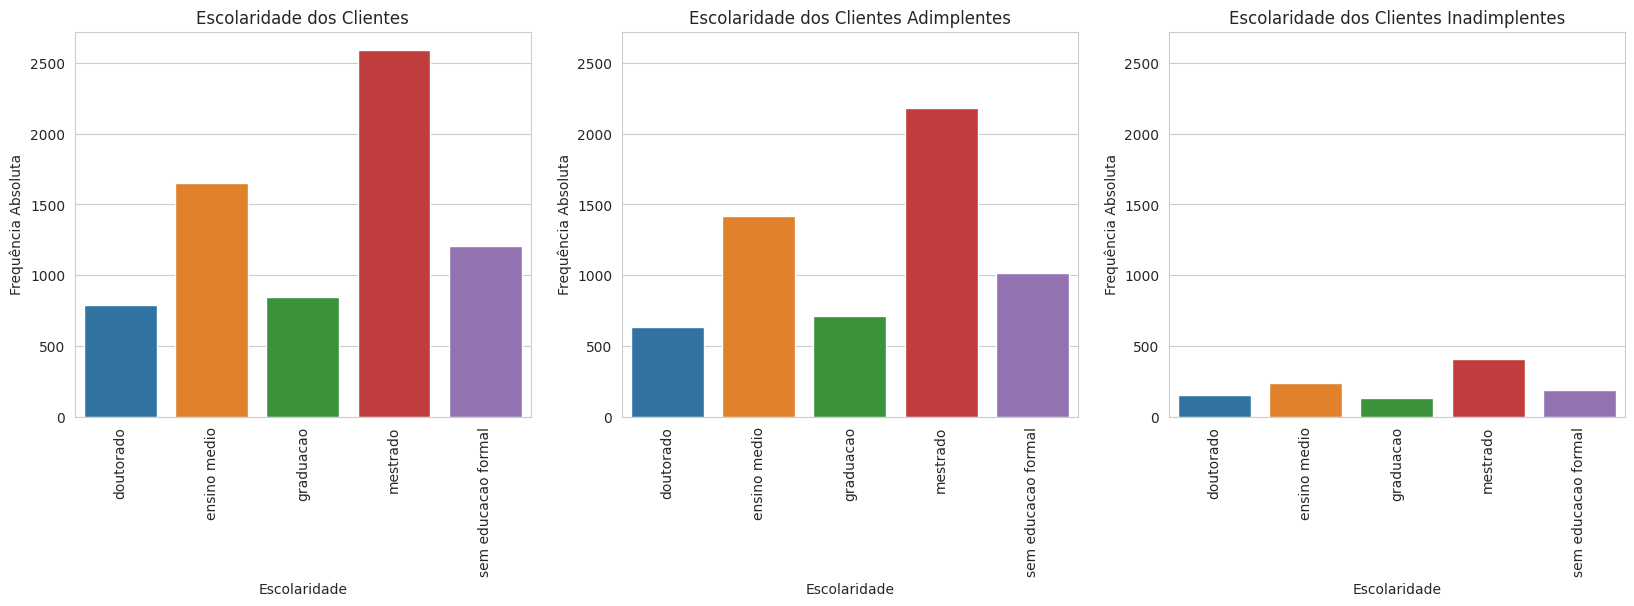

In [25]:
# Vamos chamar o método criado e analisar a coluna "escolaridade"

tabela_coluna_cat(coluna='escolaridade',
                  titulos = ['Escolaridade dos Clientes',
                             'Escolaridade dos Clientes Adimplentes',
                             'Escolaridade dos Clientes Inadimplentes']
                  )

Analisando o gráfico, percebemos que a proporção é mantida tanto no banco de dados geral quanto nos grupos.

Sendo assim, não vemos nenhuma ligação entre o nível de escolaridade dos clientes e o pagamento ou não de suas dívidas.

 - Estado Civil

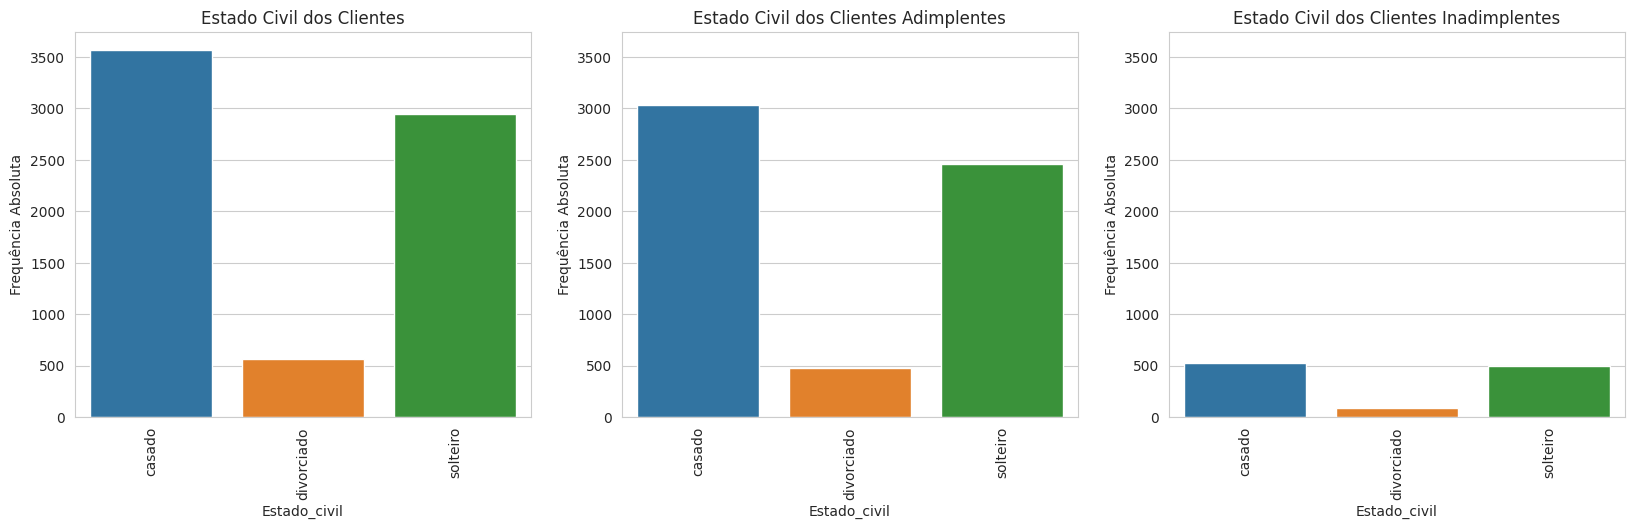

In [26]:
tabela_coluna_cat(coluna='estado_civil',
                  titulos = ['Estado Civil dos Clientes',
                             'Estado Civil dos Clientes Adimplentes',
                             'Estado Civil dos Clientes Inadimplentes']
                  )

Mais uma vez percebemos que a proporção é mantida e não vemos nenhuma ligação entre o estado civil dos clientes e a adimplência ou inadimplência.

 - Salário anual

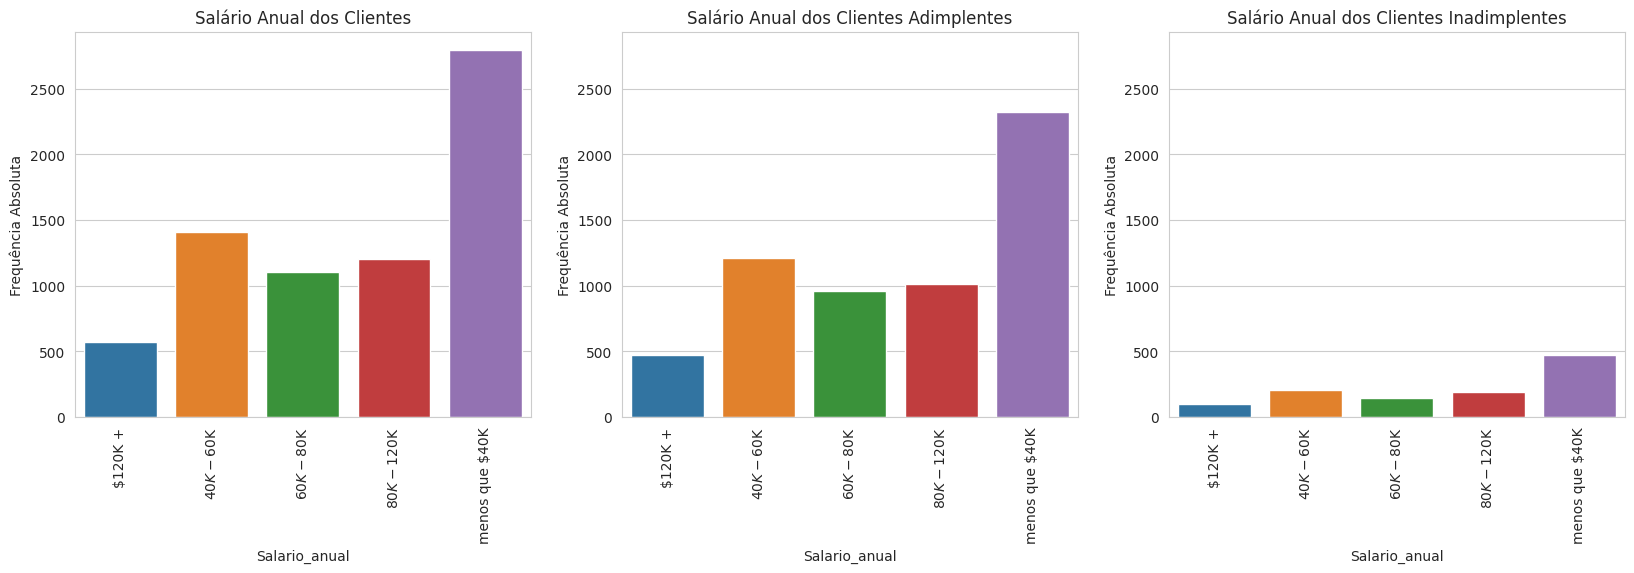

In [27]:
tabela_coluna_cat(coluna='salario_anual',
                  titulos = ['Salário Anual dos Clientes',
                             'Salário Anual dos Clientes Adimplentes',
                             'Salário Anual dos Clientes Inadimplentes']
                  )

Novamente, a configuração dos grupos permanece no mesmo padrão e não intefere na nossa análise.



 - Tipo de Cartão

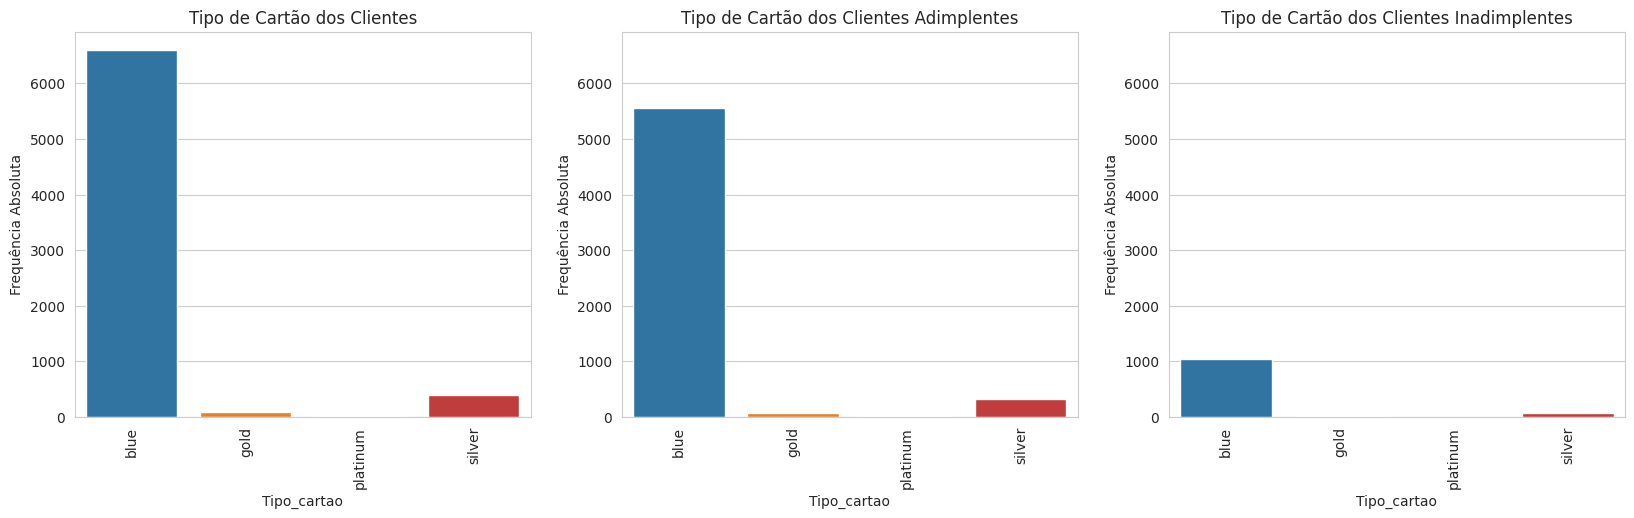

In [28]:
tabela_coluna_cat(coluna='tipo_cartao',
                  titulos = ['Tipo de Cartão dos Clientes',
                             'Tipo de Cartão dos Clientes Adimplentes',
                             'Tipo de Cartão dos Clientes Inadimplentes']
                  )

Percebemos que, como nas outras colunas, identificamos o mesmo padrão. Esse dado também não intefere na nossa análise.

### 3.2 Visualização dos dados numéricos

Agora vamos analisar a relação entre a nossa coluna de interesse e as colunas numéricas.

In [29]:
df.drop(['id', 'default'], axis=1).select_dtypes('number').head(n=0)

,idade,dependentes,meses_de_relacionamento,qtd_produtos,iteracoes_12m,meses_inativo_12m,limite_credito,valor_transacoes_12m,qtd_transacoes_12m


Vamos criar um método para a nossa análise.

In [30]:
def tabela_coluna_num (coluna, titulos):

    eixo = 0
    max_y = 0
    figura, eixos = plt.subplots(1,3, figsize=(20, 5), sharex=True)

    for dataframe in [df, df_adimplente, df_inadimplente]:

      f = sns.histplot(x=coluna, data=dataframe, stat='count', ax=eixos[eixo])
      f.set(title=titulos[eixo], xlabel=coluna.capitalize(), ylabel='Frequência Absoluta')

      _, max_y_f = f.get_ylim()
      max_y = max_y_f if max_y_f > max_y else max_y
      f.set(ylim=(0, max_y))

      eixo += 1

    figura.show()

 - Idade

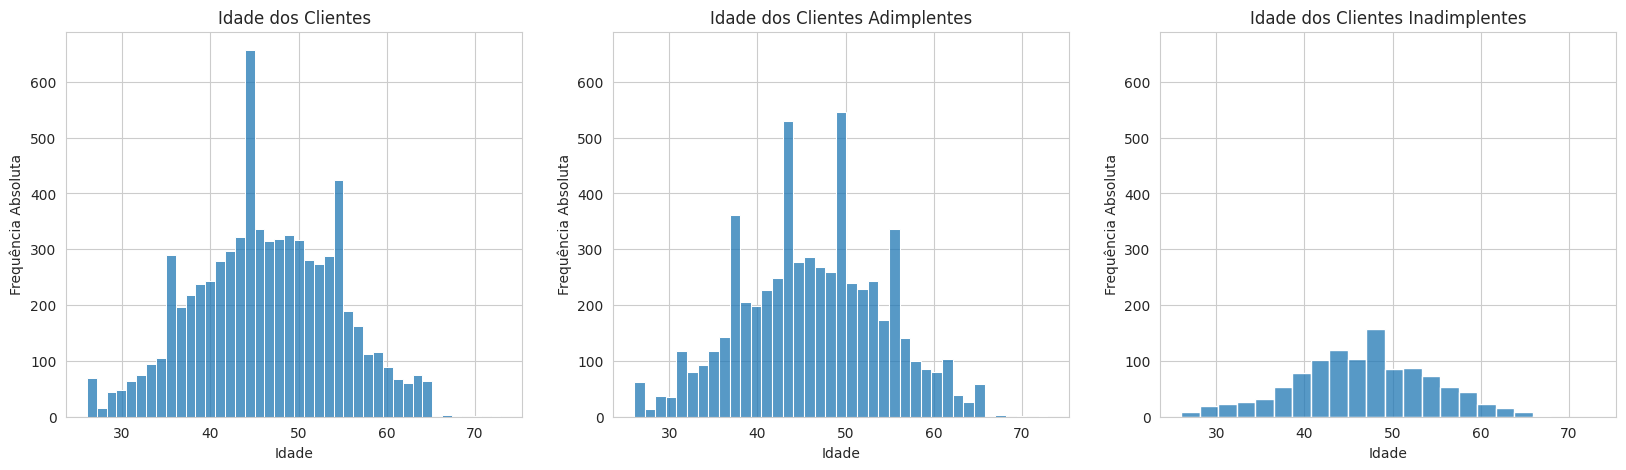

In [31]:
tabela_coluna_num (coluna = 'idade',
                   titulos = ['Idade dos Clientes',
                              'Idade dos Clientes Adimplentes',
                              'Idade dos Clientes Inadimplentes']
                   )

Na coluna idade, apesar de os picos do gráfico inicial não se apresentarem no gráfico de clientes inadimplentes, não é suficiente para percebermos uma ligação clara entre a idade e a situação financeira do cliente.

 - Dependentes

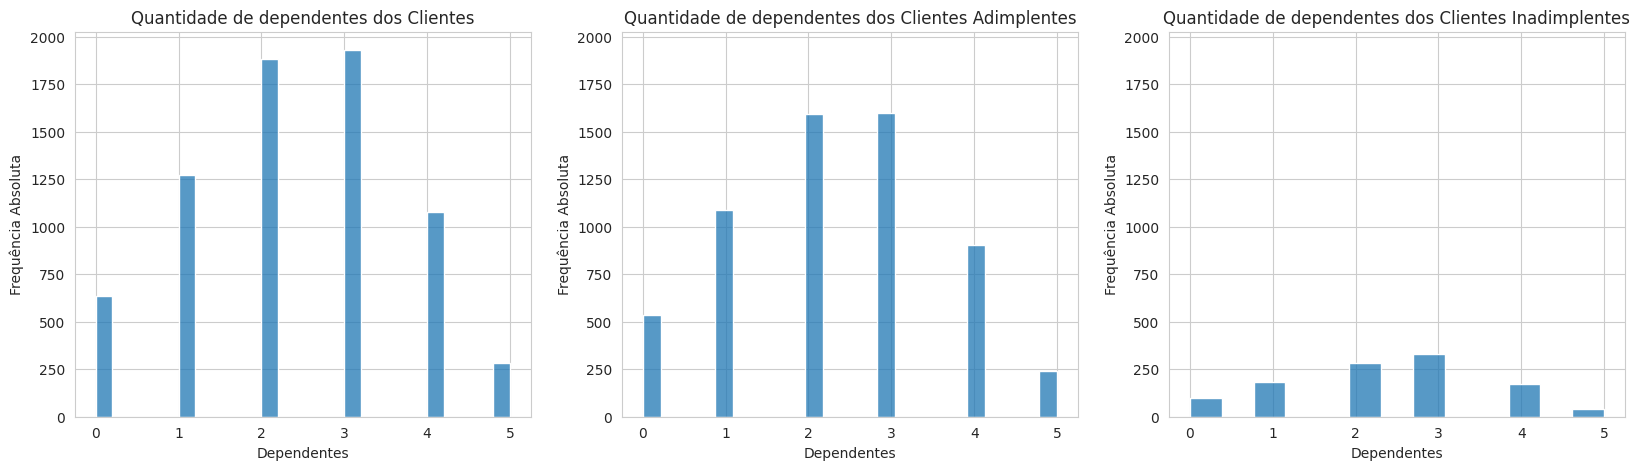

In [32]:
tabela_coluna_num (coluna = 'dependentes',
                   titulos = ['Quantidade de dependentes dos Clientes',
                              'Quantidade de dependentes dos Clientes Adimplentes',
                              'Quantidade de dependentes dos Clientes Inadimplentes']
                   )

Nessa coluna identificamos o mesmo padrão em todos os gráficos. Sendo assim, ainda não conseguimos encontrar conexões com a coluna de interesse.

 - Meses de relacionamento

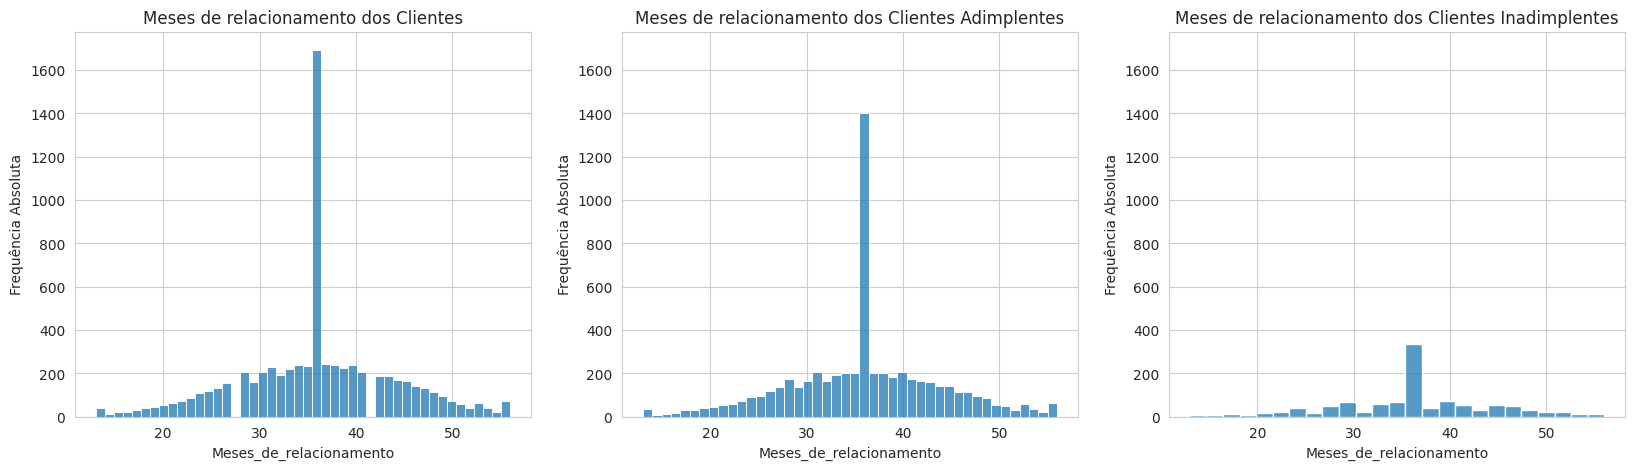

In [33]:
tabela_coluna_num (coluna = 'meses_de_relacionamento',
                   titulos = ['Meses de relacionamento dos Clientes',
                              'Meses de relacionamento dos Clientes Adimplentes',
                              'Meses de relacionamento dos Clientes Inadimplentes']
                   )

Novamente, a configuração dos grupos permanece no mesmo padrão.

 - Quantidade de produtos contratados

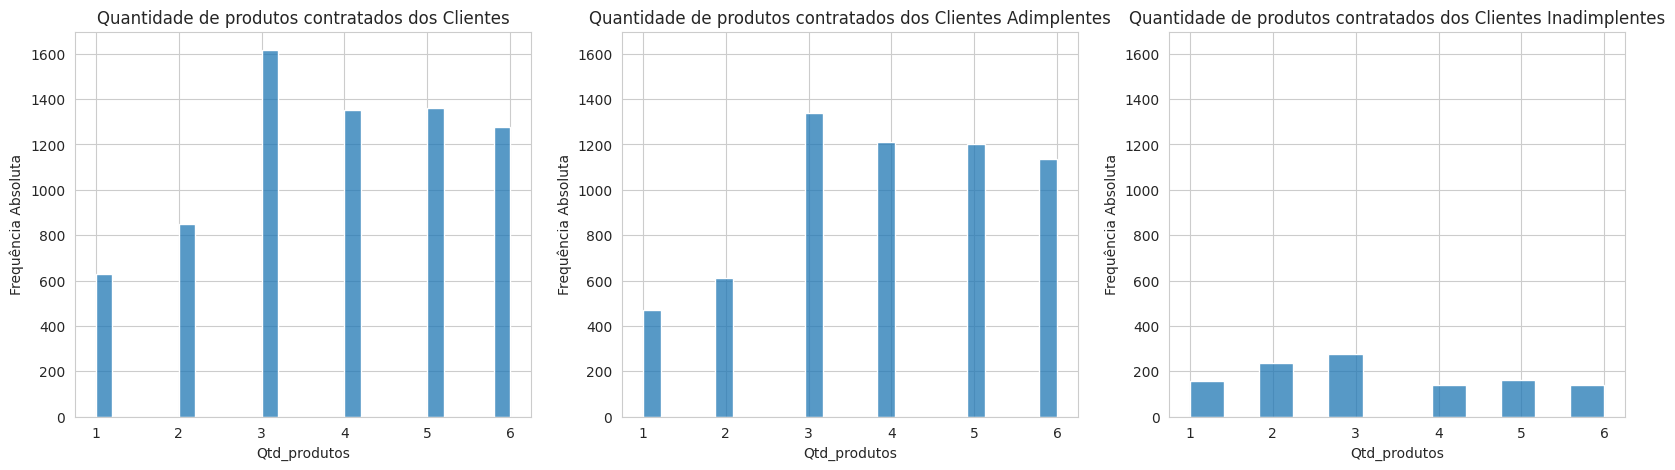

In [34]:
tabela_coluna_num (coluna = 'qtd_produtos',
                   titulos = ['Quantidade de produtos contratados dos Clientes',
                              'Quantidade de produtos contratados dos Clientes Adimplentes',
                              'Quantidade de produtos contratados dos Clientes Inadimplentes']
                   )


Mais uma vez, o padrão segue em todos os gráficos.

 - Interações em 12 meses

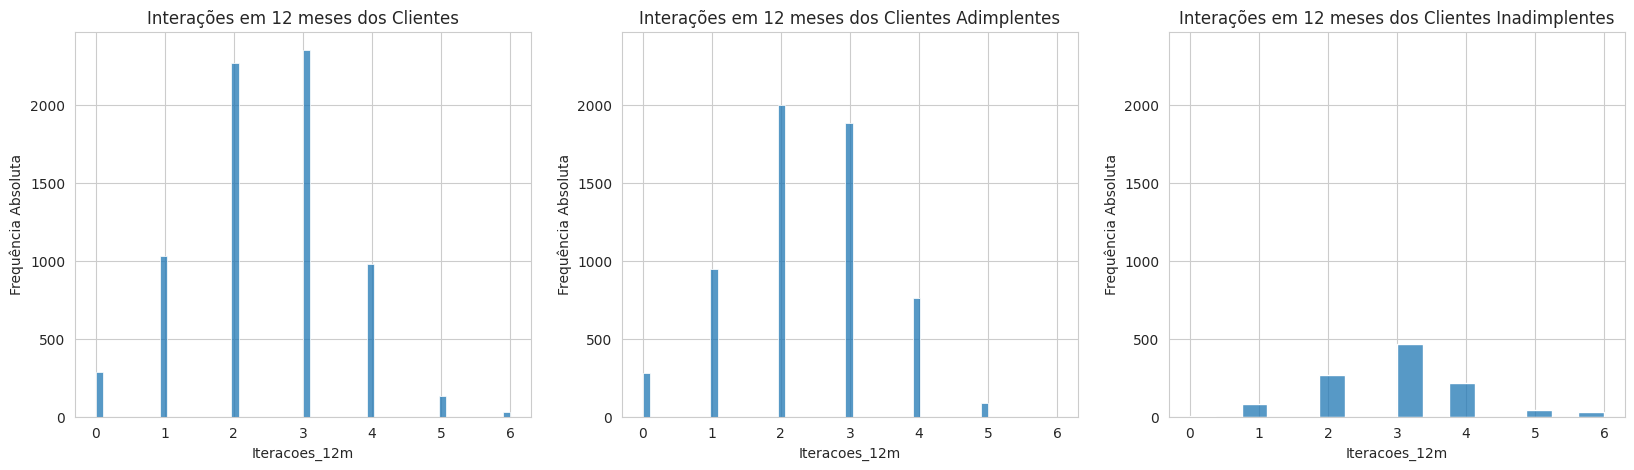

In [35]:
tabela_coluna_num (coluna = 'iteracoes_12m',
                   titulos = ['Interações em 12 meses dos Clientes',
                              'Interações em 12 meses dos Clientes Adimplentes',
                              'Interações em 12 meses dos Clientes Inadimplentes']
                   )

Percebemos que o número de interações com o banco também não influencia no pagamento ou não das dívidas.

 - Meses inativo nos últimos 12 meses

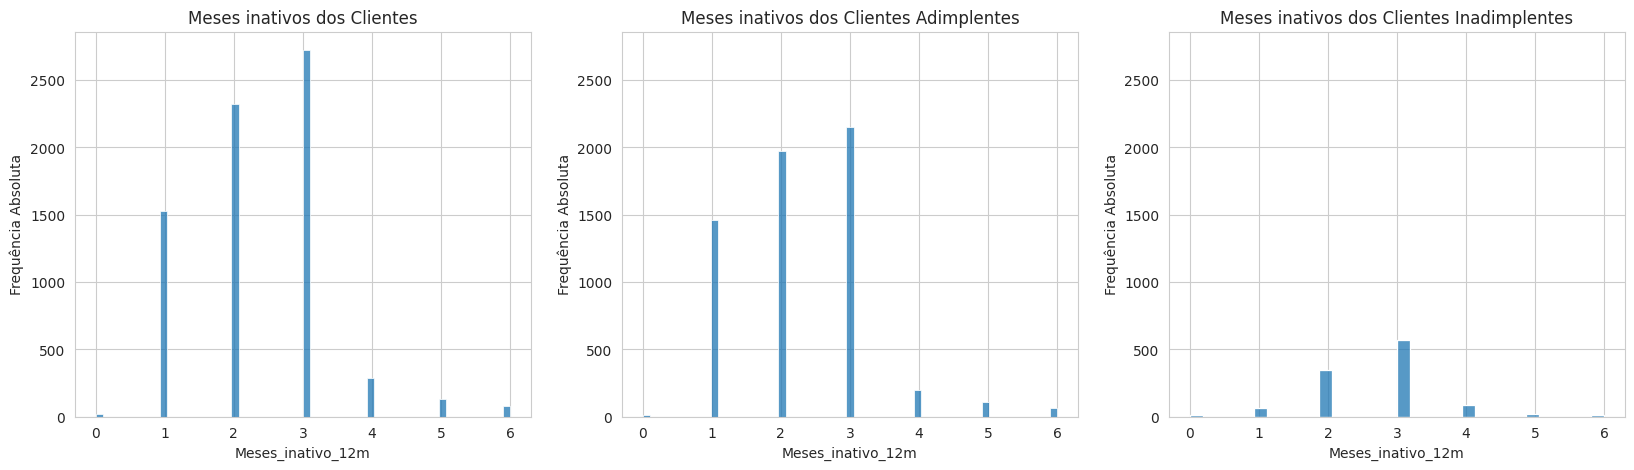

In [36]:
tabela_coluna_num (coluna = 'meses_inativo_12m',
                   titulos = ['Meses inativos dos Clientes',
                              'Meses inativos dos Clientes Adimplentes',
                              'Meses inativos dos Clientes Inadimplentes']
                   )

A quantidade de meses que um cliente passa inativo também não intefere na nossa análise.

 - Limite de Crédito

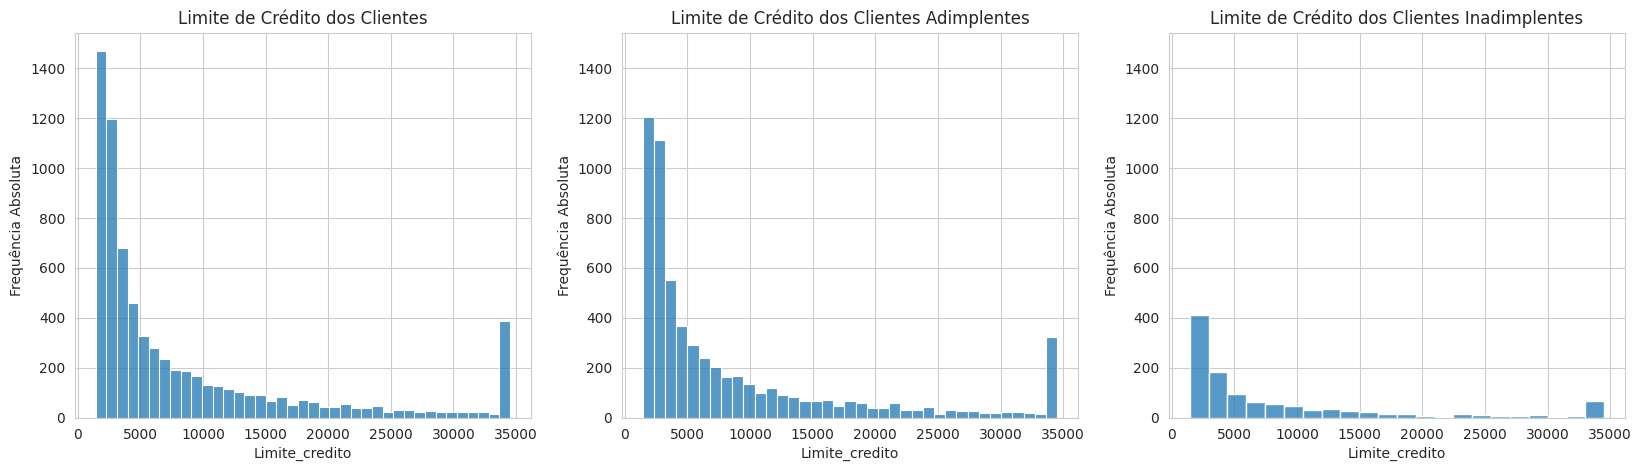

In [37]:
tabela_coluna_num (coluna = 'limite_credito',
                   titulos = ['Limite de Crédito dos Clientes',
                              'Limite de Crédito dos Clientes Adimplentes',
                              'Limite de Crédito dos Clientes Inadimplentes']
                   )

Percebemos o mesmo padrão em todos os gráficos, então não interfere na nossa análise.

 - Valor das transações nos últimos 12 meses

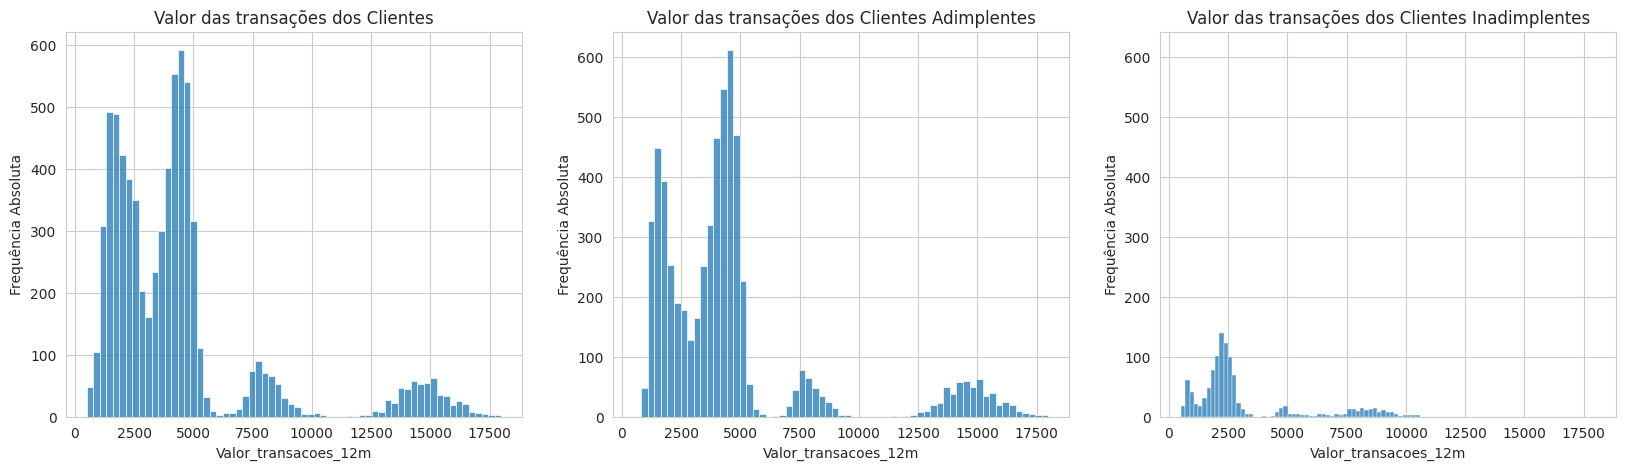

In [38]:
tabela_coluna_num (coluna = 'valor_transacoes_12m',
                   titulos = ['Valor das transações dos Clientes',
                              'Valor das transações dos Clientes Adimplentes',
                              'Valor das transações dos Clientes Inadimplentes']
                   )

Agora sim, percebemos uma clara mudança no comportamento dos clientes inadimplentes. Perceba como a grande maioria dos clientes transaciona valores abaixo de 10.000 e tem um pico perto dos 2.500.

Esse dado interfere na nossa análise.

 - Quantidade de transações nos últimos 12 meses

In [ ]:
tabela_coluna_num (coluna = 'qtd_transacoes_12m',
                   titulos = ['Quantidade de transações dos Clientes',
                              'Quantidade de transações dos Clientes Adimplentes',
                              'Quantidade de transações dos Clientes Inadimplentes']
                   )

Novamente, percebemos uma tendência nos clientes inadimplentes. Esses clientes não chegaram nem a 100 transações no último ano e tem uma maioria entre 35 - 55 transações anuais.

Essa coluna também influencia no nosso estudo.

### 3.3 Relacionando os dados de interesse

 - Valor de Transações nos Últimos 12 Meses x Quantidade de Transações nos Últimos 12 Meses

Agora que sabemos quais dados interferem na nossa análise, vamos ver qual a relação entre eles.

In [ ]:
f = sns.relplot(x='valor_transacoes_12m', y='qtd_transacoes_12m', data=df, hue='default')
_ = f.set(
    title='Relação entre Valor e Quantidade de Transações no Último Ano',
    xlabel='Valor das Transações no Último Ano',
    ylabel='Quantidade das Transações no Último Ano'
  )

Sabendo que os clientes em azul identificados por "0" são os adimplentes e os clientes em laranja identificados por "1" são os inadimplentes, vamos às nossas conclusões.

## 4. Insights

Já que finalizamos nossa análise dos dados, vamos às nossas conclusões finais:

- Percebemos que idade, número de dependentes, nível de escolaridade, estado civil, salario, tipo de cartão, meses de relacionamento com a instituição, quantidade de produtos contratados, quantidade de interações com o banco, meses de inatividade e limite de crédito não interferem no pagamento das dívidas.

- Com esses dados, pudemos perceber que o pagamento das dívidas pouco tem a ver com o estilo de vida, situação financeira ou com a formação.

- Porém, o que percebemos é que a média do valor das transações dos inadimplentes é mais baixa.

- Notamos também que eles movimentam a conta com menos frequência.

- Mas o maior insight que pudemos encontrar é que quanto menor a quantidade de transações e menor o valor movimentado, maiores são as chances de o cliente ficar inadimplente.

- Paralelamente a isso, com mais transações e maiores valores movimentados, os níveis de adimplência são altíssimos.

Com esses dados em mãos, fica muito mais fácil para a instituição financeira prever quais clientes tem maiores chances de não pagarem suas dívidas em dia e evitar assim possíveis prejuízos.